Day 2

In [ ]:
class Order:
    def __init__(self, order_id, side, price, qty, timestamp):
        self.id = order_id
        self.side = side        # 'buy' or 'sell'
        self.price = price
        self.qty = qty
        self.ts = timestamp

In [ ]:
class OrderBook:
    def __init__(self):
        self.bids = []   # list of buy orders
        self.asks = []   # list of sell orders
        self.trades = []

    def add_order(self, order):
        if order.side == 'buy':
            self.bids.append(order)
            # sort: highest price first, then earlier time
            self.bids.sort(key=lambda o: (-o.price, o.ts))
        else:
            self.asks.append(order)
            # sort: lowest price first, then earlier time
            self.asks.sort(key=lambda o: (o.price, o.ts))

        self.match()

    def match(self):
        while self.bids and self.asks and self.bids[0].price >= self.asks[0].price:
            buy = self.bids[0]
            sell = self.asks[0]

            traded_qty = min(buy.qty, sell.qty)

            self.trades.append(
                (buy.id, sell.id, sell.price, traded_qty)
            )

            buy.qty -= traded_qty
            sell.qty -= traded_qty

            if buy.qty == 0:
                self.bids.pop(0)
            if sell.qty == 0:
                self.asks.pop(0)

    def print_top5(self):
        print("\nBUY SIDE")
        for o in self.bids[:5]:
            print(o.price, o.qty)

        print("SELL SIDE")
        for o in self.asks[:5]:
            print(o.price, o.qty)

In [ ]:
book = OrderBook()
t = 0
bb_series = []
ba_series = []

def send(side, price, qty):
    global t
    t += 1
    order = Order(t, side, price, qty, t)
    book.add_order(order)
    bb = book.bids[0].price if book.bids else None
    ba = book.asks[0].price if book.asks else None
    bb_series.append(bb)
    ba_series.append(ba)
    book.print_top5()

In [ ]:
send('buy', 99, 10)
send('buy', 98, 15)
send('sell', 100, 12)
send('sell', 101, 10)

send('buy', 100, 6)   # market-like crossing
send('sell', 99, 8)


BUY SIDE
99 10
SELL SIDE

BUY SIDE
99 10
98 15
SELL SIDE

BUY SIDE
99 10
98 15
SELL SIDE
100 12

BUY SIDE
99 10
98 15
SELL SIDE
100 12
101 10

BUY SIDE
99 10
98 15
SELL SIDE
100 6
101 10

BUY SIDE
99 2
98 15
SELL SIDE
100 6
101 10


In [ ]:
def run_simulation():
    book = OrderBook()
    t = 0
    orders = [
        ('buy', 99, 10),
        ('buy', 98, 15),
        ('sell', 100, 12),
        ('sell', 101, 10),
        ('buy', 100, 6),
        ('sell', 99, 8),
    ]

    for side, price, qty in orders:
        t += 1
        book.add_order(Order(t, side, price, qty, t))

    return book.trades

In [ ]:
print(run_simulation())
print(run_simulation())

[(5, 3, 100, 6), (1, 6, 99, 8)]
[(5, 3, 100, 6), (1, 6, 99, 8)]


Day 3

In [ ]:
from collections import defaultdict

def aggregate_depth(orders):
    levels = defaultdict(int)
    for o in orders:
        levels[o.price] += o.qty
    return dict(sorted(levels.items()))

In [ ]:
bid_depth = aggregate_depth(book.bids)
ask_depth = aggregate_depth(book.asks)

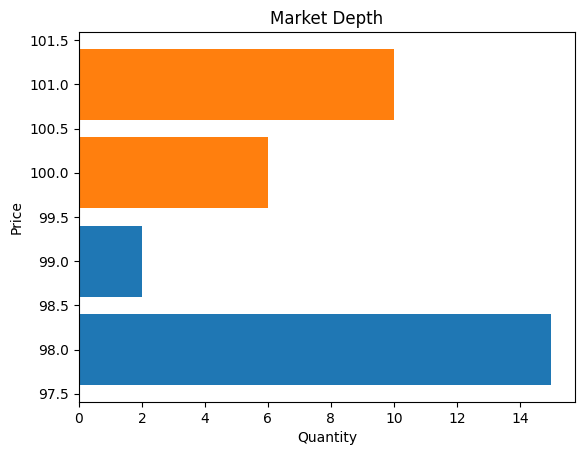

In [ ]:
import matplotlib.pyplot as plt

prices_b = list(bid_depth.keys())
qtys_b = list(bid_depth.values())

prices_a = list(ask_depth.keys())
qtys_a = list(ask_depth.values())

plt.barh(prices_b, qtys_b)
plt.barh(prices_a, qtys_a)
plt.xlabel("Quantity")
plt.ylabel("Price")
plt.title("Market Depth")
plt.show()

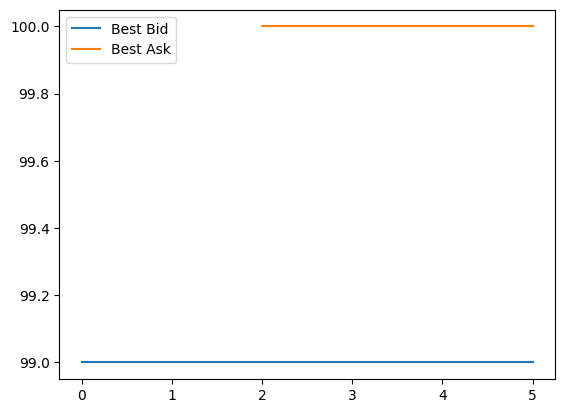

In [ ]:
plt.plot(bb_series, label="Best Bid")
plt.plot(ba_series, label="Best Ask")
plt.legend()
plt.show()

In [ ]:
def send_market(side, qty):
    if side == 'buy':
        price = float('inf')
    else:
        price = 0
    send(side, price, qty)

In [ ]:
send_market('buy', 6)
send_market('sell', 8)


BUY SIDE
100 3
100 6
98 4
98 9
97 4
SELL SIDE
101 7
101 6
101 9
101 3
101 1

BUY SIDE
100 1
98 4
98 9
97 4
97 6
SELL SIDE
101 7
101 6
101 9
101 3
101 1


In [ ]:
import random
import numpy as np

def random_order(mid):
    side = random.choice(["buy", "sell"])
    price = int(np.random.normal(mid, 2))
    qty = random.randint(1, 10)
    return side, price, qty

In [ ]:
book = OrderBook()
bb_series = []
ba_series = []
t = 0
for _ in range(1000):
    side, price, qty = random_order(mid=100)
    t += 1
    book.add_order(Order(t, side, price, qty, t))
    bb = book.bids[0].price if book.bids else None
    ba = book.asks[0].price if book.asks else None
    bb_series.append(bb)
    ba_series.append(ba)

In [ ]:
bid_depth = aggregate_depth(book.bids)
ask_depth = aggregate_depth(book.asks)

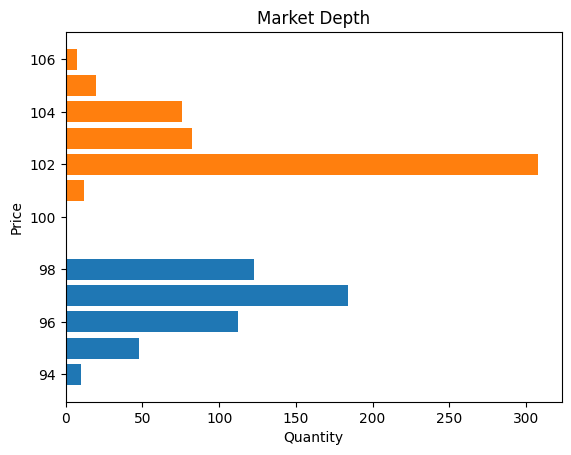

In [ ]:
prices_b = list(bid_depth.keys())
qtys_b = list(bid_depth.values())

prices_a = list(ask_depth.keys())
qtys_a = list(ask_depth.values())

plt.barh(prices_b, qtys_b)
plt.barh(prices_a, qtys_a)
plt.xlabel("Quantity")
plt.ylabel("Price")
plt.title("Market Depth")
plt.show()

Depth is thick near mid-price because, most traders place prices near mid and normal distribution peaks at the center. Far prices are thin since few people believe price should be 90 or 110. So, there are fewer orders and thinner depth.
Volatility depends on depth, i.e, High depth means low volatility and vice versa. For example, in a scenario with a 100 contracts sitting at price 100, a market order of size 5 barely scratches the surface and so the price doesn’t move. In other words, the market absorbs shock. On the other hand, if there are only 3 contracts at best price, a market order of size 5 wipes the level and makes it jump to the next price. Thus price moves violently and this is volatility.

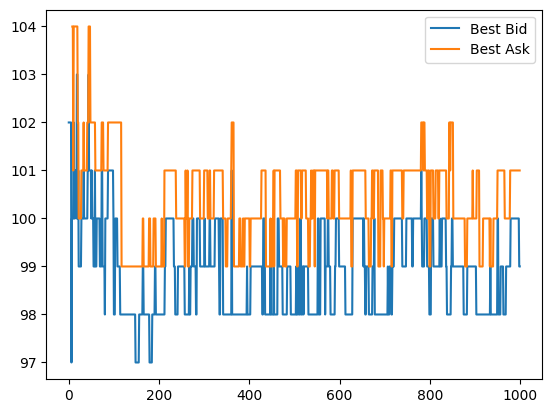

In [ ]:
plt.plot(bb_series, label="Best Bid")
plt.plot(ba_series, label="Best Ask")
plt.legend()
plt.show()

We notice that spread shrinks and stabilizes. The spread starts wide because early on there are few orders and big gaps between prices. This means that the market is risky and uncertain. Later, the spread shrinks as more traders arrive, because some bid slightly higher and some ask slightly lower. Finally, the spread stabilizes. This is beacuse, once spread is tight, improving it gives little advantage and matching risk increases. So, equilibrium forms and this is liquidity equilibrium.